## Data preprocessing

In [311]:
import pandas as pd
x_y = pd.read_csv("x_y_added_player_stat.csv")

In [312]:
x_y.drop(columns=["home_team_api_id", "away_team_api_id"], inplace=True)

In [314]:
df = x_y.iloc[:, 2:]

In [315]:
import numpy as np
home_team_formation = np.concatenate((np.array(df.columns[1:12]), np.array(df.columns[23:34])), axis=0)
home_team_stats = np.array(df.columns[67:76])

In [316]:
away_team_formation = np.concatenate((np.array(df.columns[12:23]), np.array(df.columns[34:45])), axis=0)
away_team_stats = np.array(df.columns[76:85])

In [317]:
home_player_stats = np.array(df.columns[87:505])

In [318]:
away_player_stats = np.array(df.columns[505:])

In [319]:
rearranged_feature_cols = np.concatenate((home_team_stats, home_player_stats, away_team_stats, away_player_stats), axis=0)

In [320]:
df = df[np.concatenate((rearranged_feature_cols, ['label_home']), axis=0)]

In [321]:
work_rate_unique = set()
work_rate_cols = []
for i in range(1, 12):
    work_rate_cols.append('home_player_'+str(i)+'_attacking_work_rate')
    work_rate_cols.append('away_player_'+str(i)+'_attacking_work_rate')
    work_rate_cols.append('home_player_'+str(i)+'_defensive_work_rate')    
    work_rate_cols.append('away_player_'+str(i)+'_defensive_work_rate')
for col in work_rate_cols:
    for index in df[col].value_counts().index:
        work_rate_unique.add(index)

In [322]:
for i in ["high", "low", "medium"]:
    work_rate_unique.remove(i)

In [323]:
replace_map = dict(zip(work_rate_unique, ["medium"]*len(work_rate_unique)))
for col in work_rate_cols:
    df[col].replace(replace_map, inplace=True)
    df[col].fillna("medium", inplace=True)

In [324]:
df_cleaned = df.fillna(df.mean())

In [325]:
#i used average throughout players in same position, but better would be average within the team. best is average within the same position in the team would be the best but we do not have info on that. 

In [326]:
categorical_variables = ['_preferred_foot', '_attacking_work_rate', '_defensive_work_rate']
categorical_cols = []
for i in range(1, 12):
    for cat in categorical_variables:
        categorical_cols.append('home_player_'+str(i)+cat)
for i in range(1, 12):
    for cat in categorical_variables:
        categorical_cols.append('away_player_'+str(i)+cat)

In [327]:
df_cleaned.columns[:-1]

Index(['home_buildUpPlaySpeed', 'home_buildUpPlayDribbling',
       'home_buildUpPlayPassing', 'home_chanceCreationPassing',
       'home_chanceCreationCrossing', 'home_chanceCreationShooting',
       'home_defencePressure', 'home_defenceAggression',
       'home_defenceTeamWidth', 'home_player_1_overall_rating',
       ...
       'away_player_11_vision', 'away_player_11_penalties',
       'away_player_11_marking', 'away_player_11_standing_tackle',
       'away_player_11_sliding_tackle', 'away_player_11_gk_diving',
       'away_player_11_gk_handling', 'away_player_11_gk_kicking',
       'away_player_11_gk_positioning', 'away_player_11_gk_reflexes'],
      dtype='object', length=854)

In [ ]:
# df_cleaned["match_api_id"] = x_y["match_api_id"]

In [37]:
# df_cleaned.to_csv("cleaned_data_notEncoded.csv", index=False)

## Autoencoders

In [290]:
df_temp = df_cleaned.copy()

In [776]:
player_attributes.columns[4:]

Index(['overall_rating', 'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')

In [123]:
attributes_col = player_attributes.columns[4:].tolist()
attributes_col.remove("preferred_foot")
attributes_col.remove("attacking_work_rate")
attributes_col.remove("defensive_work_rate")

In [125]:
def nameColumns(playerNum, homeOrAway):
    cols = attributes_col
    player_cols = []
    for col in cols:
        player_cols.append(homeOrAway + "_player_" + str(playerNum) + "_" + col)
    return player_cols

In [76]:
temp = df_temp[nameColumns(1, "home")].values
for i in range(2, 12):
    temp = np.concatenate((temp, df_temp[nameColumns(i, "home")].values, df_temp[nameColumns(i, "away")].values), axis=0)
autoencoder_data = pd.DataFrame(temp)
autoencoder_data.columns = attributes_col

In [80]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(autoencoder_data)
autoencoder_data = scaler.transform(autoencoder_data)

/Users/seungwooson/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [85]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(autoencoder_data, autoencoder_data[:,-1], 
                                                    test_size=0.15, random_state=0)

In [173]:
from keras.layers import Input, Dense, PReLU
from keras.models import Model
from keras import optimizers

encoding_dim = 3

input_img = Input(shape=(autoencoder_data.shape[1],))
encoded = Dense(15, activation=PReLU())(input_img)
# encoded = Dense(16, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation=PReLU())(encoded)

decoded = Dense(15, activation=PReLU())(encoded)
# decoded = Dense(32, activation='relu')(decoded)
decoded = Dense(autoencoder_data.shape[1], activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)

encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-2](encoded_input)
# decoder_layer = autoencoder.layers[-2](decoder_layer)
decoder_layer = autoencoder.layers[-1](decoder_layer)
decoder = Model(encoded_input, decoder_layer)

adam = optimizers.Adam(lr=5e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
autoencoder.compile(optimizer=adam, loss='mse')

autoencoder.fit(X_train, X_train,
                epochs=10,
                batch_size=64,
                shuffle=True,
                validation_data=(X_test, X_test))

/Users/seungwooson/anaconda/lib/python3.5/site-packages/keras/activations.py:115: UserWarning: Do not pass a layer instance (such as PReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Train on 358071 samples, validate on 63189 samples
Epoch 1/10
358071/358071 [==============================] - 13s 36us/step - loss: 0.0284 - val_loss: 0.0153
Epoch 2/10
358071/358071 [==============================] - 12s 35us/step - loss: 0.0123 - val_loss: 0.0106
Epoch 3/10
358071/358071 [==============================] - 12s 33us/step - loss: 0.0097 - val_loss: 0.0088
Epoch 4/10
358071/358071 [==============================] - 12s 34us/step - loss: 0.0082 - val_loss: 0.0078
Epoch 5/10
358071/358071 [==============================] - 12s 33us/step - loss: 0.0076 - val_loss: 0.0074
Epoch 6/10
358071/358071 [==============================] - 12s 34us/step - loss: 0.0074 - val_loss: 0.0073
Epoch 7/10
358071/358071 [==============================] - 12s 34us/step - loss: 0.0072 - val_loss: 0.0072
Epoch 8/10
358071/358071 [==============================] - 13s 37us/step - loss: 0.0071 - val_loss: 0.0071
Epoch 9/10
358071/358071 [==============================] - 13s 37us/step - loss: 0.0

In [186]:
print("Reduced player stat dimensions from %d dimensions -> %d dimensions" % (autoencoder_data.shape[1]*11*2, encoding_dim*11*2))

Reduced player stat dimensions from 770 dimensions -> 66 dimensions


In [ ]:
maybe take out overall stat, take out gk?

In [185]:
encoder.predict(df_temp[nameColumns(11, "home")].values)

array([[778.6596 , 430.97665, 422.58862],
       [850.8912 , 484.18942, 438.37717],
       [920.72797, 465.07742, 498.03577],
       ...,
       [791.35583, 476.00183, 260.3753 ],
       [936.47595, 306.2982 , 310.84268],
       [971.364  , 346.57587, 304.6196 ]], dtype=float32)

## Baseline without Categories

In [471]:
df_temp = df_cleaned.copy()

In [472]:
non_numeric_cols = np.concatenate((categorical_cols, home_team_formation, away_team_formation), axis=0)
numeric_cols = [col for col in df_temp.columns[:-1] if col not in non_numeric_cols]

In [473]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(df_temp[numeric_cols])
df_temp[numeric_cols] = scaler.transform(df_temp[numeric_cols])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_temp[numeric_cols], df_temp.iloc[:,-1], 
                                                    test_size=0.15, random_state=0)
from keras.utils import np_utils
y_train, y_test = [i+1 for i in y_train], [i+1 for i in y_test]
y_train_enc, y_test_enc = np_utils.to_categorical(y_train), np_utils.to_categorical(y_test)

In [428]:
import keras
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import SGD
opt = SGD(lr=1e-5)
# adam = keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
from keras.initializers import glorot_normal

def MLP(input_dim):
    xavier_init = glorot_normal(seed=35)
    model = Sequential()
    model.add(Dense(units=32, activation='relu', kernel_initializer=xavier_init, input_dim=input_dim))
    model.add(Dense(units=16, activation='relu', kernel_initializer=xavier_init))
    model.add(Dense(units=3, activation='softmax', kernel_initializer=xavier_init))
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

model = MLP(X_train.shape[1])
model.fit(x=X_train, y=y_train_enc, validation_data=(X_test, y_test_enc), batch_size=32, epochs=50)

Train on 17051 samples, validate on 3009 samples
Epoch 1/50
17051/17051 [==============================] - 4s 234us/step - loss: 1.1936 - acc: 0.2582 - val_loss: 1.1675 - val_acc: 0.2629
Epoch 2/50
17051/17051 [==============================] - 2s 112us/step - loss: 1.1685 - acc: 0.2583 - val_loss: 1.1465 - val_acc: 0.2659
Epoch 3/50
17051/17051 [==============================] - 2s 112us/step - loss: 1.1510 - acc: 0.2595 - val_loss: 1.1312 - val_acc: 0.2702
Epoch 4/50
17051/17051 [==============================] - 2s 112us/step - loss: 1.1379 - acc: 0.2671 - val_loss: 1.1198 - val_acc: 0.2815
Epoch 5/50
17051/17051 [==============================] - 2s 112us/step - loss: 1.1278 - acc: 0.2823 - val_loss: 1.1109 - val_acc: 0.2981
Epoch 6/50
17051/17051 [==============================] - 2s 110us/step - loss: 1.1197 - acc: 0.3054 - val_loss: 1.1038 - val_acc: 0.3177
Epoch 7/50
17051/17051 [==============================] - 2s 110us/step - loss: 1.1133 - acc: 0.3307 - val_loss: 1.0981 - v

In [429]:
model.evaluate(X_test, y_test_enc)

3009/3009 [==============================] - 0s 71us/step


[1.0616693132816655, 0.4709205716184779]

## Baseline with Categories

In [329]:
df_with_category = df_cleaned.copy()

In [359]:
categorical_variables = ['_preferred_foot', '_attacking_work_rate', '_defensive_work_rate']
categorical_cols = []
for i in range(1, 12):
    for cat in categorical_variables:
        categorical_cols.append('home_player_'+str(i)+cat)
for i in range(1, 12):
    for cat in categorical_variables:
        categorical_cols.append('away_player_'+str(i)+cat)

In [330]:
non_numeric_cols = np.concatenate((categorical_cols, home_team_formation, away_team_formation), axis=0)
numeric_cols = [col for col in df_with_category.columns[:-1] if col not in non_numeric_cols]

In [331]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(df_with_category[numeric_cols])

In [332]:
df_with_category[numeric_cols] = scaler.transform(df_with_category[numeric_cols])

In [360]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_with_category.iloc[:,:-1], df_with_category.iloc[:,-1], 
                                                    test_size=0.15, random_state=0)

In [370]:
X_train_dummy = pd.get_dummies(pd.DataFrame(X_train, columns=df_with_category.iloc[:,:-1].columns), columns=categorical_cols)
X_test_dummy = pd.get_dummies(pd.DataFrame(X_test, columns=df_with_category.iloc[:,:-1].columns), columns=categorical_cols)

In [389]:
home_non_dummy = np.array(X_train_dummy.columns[:394])
away_non_dummy = np.array(X_train_dummy.columns[394:788])

In [402]:
home_dummy_col = np.array(X_train_dummy.columns[788:873])
away_dummy_col = np.array(X_train_dummy.columns[873:])

In [409]:
rearranged_feature_cols = np.concatenate((home_non_dummy, home_dummy_col, away_non_dummy, away_dummy_col), axis=0)

In [410]:
X_train_dummy = X_train_dummy[rearranged_feature_cols]
missing_cols = set(X_train_dummy.columns)-set(X_test_dummy.columns)
for c in missing_cols:
    X_test_dummy[c] = 0
X_test_dummy = X_test_dummy[X_train_dummy.columns]

In [413]:
gk_cols = []
for i in range(2, 12):
    gk_cols.append("home_player_"+str(i)+"_gk_diving")
    gk_cols.append("home_player_"+str(i)+"_gk_handling")
    gk_cols.append("home_player_"+str(i)+"_gk_kicking")
    gk_cols.append("home_player_"+str(i)+"_gk_positioning")
    gk_cols.append("home_player_"+str(i)+"_gk_reflexes")
    gk_cols.append("away_player_"+str(i)+"_gk_diving")
    gk_cols.append("away_player_"+str(i)+"_gk_handling")
    gk_cols.append("away_player_"+str(i)+"_gk_kicking")
    gk_cols.append("away_player_"+str(i)+"_gk_positioning")
    gk_cols.append("away_player_"+str(i)+"_gk_reflexes")
X_train_final = X_train_dummy.drop(columns=gk_cols)
X_test_final = X_test_dummy.drop(columns=gk_cols)

In [411]:
from keras.utils import np_utils
y_train, y_test = [i+1 for i in y_train], [i+1 for i in y_test]
y_train_encoded = np_utils.to_categorical(y_train)
y_test_encoded = np_utils.to_categorical(y_test)

In [414]:
import keras
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

def MLP(input_dim):
    model = Sequential()
    model.add(Dense(units=32, activation=ELU(), input_dim=input_dim))
#     model.add(Dropout(0.8))
    model.add(Dense(units=16, activation=ELU()))
    model.add(Dense(units=3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

model = MLP(X_train_final.shape[1])
model.fit(x=X_train_final, y=y_train_encoded, validation_data=(X_test_final, y_test_encoded), batch_size=32, epochs=50)

/Users/seungwooson/anaconda/lib/python3.5/site-packages/keras/activations.py:115: UserWarning: Do not pass a layer instance (such as ELU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Train on 17051 samples, validate on 3009 samples
Epoch 1/50
17051/17051 [==============================] - 4s 251us/step - loss: 1.0822 - acc: 0.4423 - val_loss: 1.0657 - val_acc: 0.4716
Epoch 2/50
17051/17051 [==============================] - 2s 123us/step - loss: 1.0735 - acc: 0.4501 - val_loss: 1.0641 - val_acc: 0.4713
Epoch 3/50
17051/17051 [==============================] - 2s 124us/step - loss: 1.0712 - acc: 0.4537 - val_loss: 1.0733 - val_acc: 0.4573
Epoch 4/50
17051/17051 [==============================] - 2s 124us/step - loss: 1.0690 - acc: 0.4545 - val_loss: 1.0623 - val_acc: 0.4713
Epoch 5/50
17051/17051 [==============================] - 2s 126us/step - loss: 1.0671 - acc: 0.4546 - val_loss: 1.0669 - val_acc: 0.4703
Epoch 6/50
17051/17051 [==============================] - 2s 123us/step - loss: 1.0670 - acc: 0.4544 - val_loss: 1.0695 - val_acc: 0.4676
Epoch 7/50
17051/17051 [==============================] - 2s 128us/step - loss: 1.0654 - acc: 0.4562 - val_loss: 1.0649 - v

In [415]:
model.evaluate(X_test_final, y_test_encoded)

3009/3009 [==============================] - 0s 77us/step


[1.0891221275991996, 0.46925888999667664]

## With Features Generated by Autoencoders, without Categories

In [430]:
df_temp = df_cleaned.copy()

In [436]:
non_numeric_cols = np.concatenate((categorical_cols, home_team_formation, away_team_formation), axis=0)
numeric_cols = [col for col in df_temp.columns[:-1] if col not in non_numeric_cols]
df_X = df_temp[numeric_cols]
y_label = df_temp.iloc[:, -1]

In [456]:
df_X_emb = df_X[home_team_stats]
for i in range(1, 12):
    df_X_emb = pd.concat([df_X_emb, pd.DataFrame(encoder.predict(df_X[nameColumns(i, "home")].values))], axis=1)
df_X_emb = pd.concat([df_X_emb, df_X[away_team_stats]], axis=1)
for i in range(1, 12):
    df_X_emb = pd.concat([df_X_emb, pd.DataFrame(encoder.predict(df_X[nameColumns(i, "away")].values))], axis=1)

In [460]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(df_X_emb)
df_X_emb = scaler.transform(df_X_emb)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_X_emb, y_label, 
                                                    test_size=0.15, random_state=0)
from keras.utils import np_utils
y_train, y_test = [i+1 for i in y_train], [i+1 for i in y_test]
y_train_enc, y_test_enc = np_utils.to_categorical(y_train), np_utils.to_categorical(y_test)

/Users/seungwooson/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [469]:
import keras
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import SGD
opt = SGD(lr=1e-4)
# opt = keras.optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
from keras.initializers import glorot_normal

def MLP(input_dim):
    model = Sequential()
    model.add(Dense(units=32, activation='relu', input_dim=input_dim))
    model.add(Dense(units=16, activation='relu'))
    model.add(Dense(units=3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

model = MLP(X_train.shape[1])
model.fit(x=X_train, y=y_train_enc, validation_data=(X_test, y_test_enc), batch_size=12, epochs=50)

Train on 17051 samples, validate on 3009 samples
Epoch 1/50
17051/17051 [==============================] - 6s 329us/step - loss: 1.1376 - acc: 0.2755 - val_loss: 1.1059 - val_acc: 0.3167
Epoch 2/50
17051/17051 [==============================] - 3s 202us/step - loss: 1.0917 - acc: 0.3864 - val_loss: 1.0805 - val_acc: 0.4506
Epoch 3/50
17051/17051 [==============================] - 3s 200us/step - loss: 1.0777 - acc: 0.4461 - val_loss: 1.0716 - val_acc: 0.4686
Epoch 4/50
17051/17051 [==============================] - 3s 200us/step - loss: 1.0730 - acc: 0.4537 - val_loss: 1.0682 - val_acc: 0.4716
Epoch 5/50
17051/17051 [==============================] - 3s 197us/step - loss: 1.0712 - acc: 0.4545 - val_loss: 1.0666 - val_acc: 0.4709
Epoch 6/50
17051/17051 [==============================] - 3s 195us/step - loss: 1.0705 - acc: 0.4552 - val_loss: 1.0657 - val_acc: 0.4709
Epoch 7/50
17051/17051 [==============================] - 3s 198us/step - loss: 1.0701 - acc: 0.4550 - val_loss: 1.0651 - v

In [470]:
model.evaluate(X_test, y_test_enc)

3009/3009 [==============================] - 0s 76us/step


[1.0616863330918398, 0.4709205716184779]

## Reproduction of Maksim's Code

In [479]:
%matplotlib inline
import pandas as pd
from pandas import Series
import numpy as np
from functools import reduce
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dense, Lambda
from keras.initializers import glorot_normal
from keras.optimizers import Adam
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from numpy import array
from keras.utils import to_categorical
import tensorflow as tf
from sklearn.metrics import recall_score, precision_score, precision_recall_fscore_support
import sqlite3
import keras
from scipy.special import softmax
from sklearn.metrics import accuracy_score

In [509]:
%%capture
from tqdm import tqdm_notebook
from tqdm import tnrange

In [481]:
data = pd.read_csv("./cleaned_data_notEncoded.csv")

data['label_away'] = data['label_home'].apply(lambda x: -1 * x)

data['home_won'] = data['label_home'].apply(lambda x: 1 if x == 1 else 0)
data['home_loss'] = data['label_home'].apply(lambda x: 1 if x == -1 else 0)
data['home_draw'] = data['label_home'].apply(lambda x: 1 if x == 0 else 0)

data['away_won'] = data['label_away'].apply(lambda x: 1 if x == 1 else 0)
data['away_loss'] = data['label_away'].apply(lambda x: 1 if x == -1 else 0)
data['away_draw'] = data['label_away'].apply(lambda x: 1 if x == 0 else 0)

In [482]:
data.head()

,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,...,away_player_11_gk_reflexes,label_home,match_api_id,label_away,home_won,home_loss,home_draw,away_won,away_loss,away_draw
0,1.0,2.0,4.0,6.0,8.0,2.0,4.0,6.0,8.0,4.0,...,23.0,0.0,493017,-0.0,0,0,1,0,0,1
1,1.0,2.0,4.0,6.0,8.0,2.0,4.0,6.0,8.0,4.0,...,23.0,0.0,493025,-0.0,0,0,1,0,0,1
2,1.0,2.0,4.0,6.0,8.0,2.0,4.0,6.0,8.0,4.0,...,23.0,-1.0,493027,1.0,0,1,0,1,0,0
3,1.0,2.0,4.0,6.0,8.0,2.0,4.0,6.0,8.0,4.0,...,23.0,1.0,493034,-1.0,1,0,0,0,1,0
4,1.0,2.0,4.0,6.0,8.0,2.0,4.0,6.0,8.0,4.0,...,21.0,-1.0,493045,1.0,0,1,0,1,0,0


In [484]:
conn = sqlite3.connect('soccer.sqlite')
res = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
match_data = pd.read_sql_query("SELECT * FROM Match", conn)

In [485]:
relevant_match_data = match_data[['season', 'match_api_id', 'date', 'home_team_api_id', 'away_team_api_id']]

In [495]:
data_with_season_date = pd.merge(data, relevant_match_data, on='match_api_id')

In [496]:
grouped_home = data_with_season_date.groupby(['season', 'home_team_api_id'])

In [499]:
names = []
groups = []
for name, group in grouped_home:
    names += [name]
    groups += [group]

In [503]:
new_groups = []
for i in range(len(groups)):
    df = groups[i]
    name = names[i]
    df['home_win_record'] = df['home_won'].cumsum() - (df['home_won'].cumsum() > 0)
    df['home_loss_record'] = df['home_loss'].cumsum() - (df['home_loss'].cumsum() > 0)
    df['home_draw_record'] = df['home_draw'].cumsum() - (df['home_draw'].cumsum() > 0)
    df['season'] = name[0]
    df['home_team_api_id'] = name[1]
    new_groups += [df]

In [504]:
df_home_stats = pd.concat(new_groups)
df_home_stats[['label_home', 'home_win_record']].head()

,label_home,home_win_record
3971,1.0,0
3984,1.0,1
3999,1.0,2
4013,-1.0,2
4027,0.0,2


In [505]:
df_home_stats.columns.values

array(['home_player_X1', 'home_player_X2', 'home_player_X3',
       'home_player_X4', 'home_player_X5', 'home_player_X6',
       'home_player_X7', 'home_player_X8', 'home_player_X9',
       'home_player_X10', 'home_player_X11', 'home_player_Y1',
       'home_player_Y2', 'home_player_Y3', 'home_player_Y4',
       'home_player_Y5', 'home_player_Y6', 'home_player_Y7',
       'home_player_Y8', 'home_player_Y9', 'home_player_Y10',
       'home_player_Y11', 'home_buildUpPlaySpeed',
       'home_buildUpPlayDribbling', 'home_buildUpPlayPassing',
       'home_chanceCreationPassing', 'home_chanceCreationCrossing',
       'home_chanceCreationShooting', 'home_defencePressure',
       'home_defenceAggression', 'home_defenceTeamWidth',
       'home_player_1_overall_rating', 'home_player_1_potential',
       'home_player_1_preferred_foot',
       'home_player_1_attacking_work_rate',
       'home_player_1_defensive_work_rate', 'home_player_1_crossing',
       'home_player_1_finishing', 'home_player_1_

In [506]:
grouped_away = df_home_stats.groupby(['season', 'away_team_api_id'])

In [507]:
names = []
groups = []
for name, group in grouped_away:
    names += [name]
    groups += [group]

In [511]:
new_groups = []
for i in tqdm_notebook(range(len(groups))):
    df = groups[i]
    name = names[i]
    df['away_win_record'] = df['away_won'].cumsum() - (df['away_won'].cumsum() > 0)
    df['away_loss_record'] = df['away_loss'].cumsum() - (df['away_loss'].cumsum() > 0)
    df['away_draw_record'] = df['away_draw'].cumsum() - (df['away_draw'].cumsum() > 0)
    df['season'] = name[0]
    df['away_team_api_id'] = name[1]
    new_groups += [df]

A Jupyter Widget

In [512]:
df_final = pd.concat(new_groups)

In [514]:
df_final.columns.values

array(['home_player_X1', 'home_player_X2', 'home_player_X3',
       'home_player_X4', 'home_player_X5', 'home_player_X6',
       'home_player_X7', 'home_player_X8', 'home_player_X9',
       'home_player_X10', 'home_player_X11', 'home_player_Y1',
       'home_player_Y2', 'home_player_Y3', 'home_player_Y4',
       'home_player_Y5', 'home_player_Y6', 'home_player_Y7',
       'home_player_Y8', 'home_player_Y9', 'home_player_Y10',
       'home_player_Y11', 'home_buildUpPlaySpeed',
       'home_buildUpPlayDribbling', 'home_buildUpPlayPassing',
       'home_chanceCreationPassing', 'home_chanceCreationCrossing',
       'home_chanceCreationShooting', 'home_defencePressure',
       'home_defenceAggression', 'home_defenceTeamWidth',
       'home_player_1_overall_rating', 'home_player_1_potential',
       'home_player_1_preferred_foot',
       'home_player_1_attacking_work_rate',
       'home_player_1_defensive_work_rate', 'home_player_1_crossing',
       'home_player_1_finishing', 'home_player_1_

In [515]:
# df_final.to_csv("data_cleaned_new_features.csv", index=False)

In [523]:
df_final['season'] = pd.factorize(df_final['season'])[0]

In [524]:
desired_cols = np.concatenate((home_team_stats, home_player_stats, ['home_win_record', 'home_loss_record', 'home_draw_record', 'season'], away_team_stats, away_player_stats, ['away_win_record', 'away_loss_record', 'away_draw_record']), axis=0)

In [558]:
X = df_final[desired_cols]
y = df_final['label_home']

In [527]:
df_X_emb = X[home_team_stats]
for i in tqdm_notebook(range(1, 12)):
    df_X_emb = pd.concat([df_X_emb, pd.DataFrame(encoder.predict(X[nameColumns(i, "home")].values))], axis=1)
df_X_emb = pd.concat([df_X_emb, X[['home_win_record', 'home_loss_record', 'home_draw_record', 'season']], X[away_team_stats]], axis=1)
for i in tqdm_notebook(range(1, 12)):
    df_X_emb = pd.concat([df_X_emb, pd.DataFrame(encoder.predict(X[nameColumns(i, "away")].values))], axis=1)
df_X_emb = pd.concat([df_X_emb, X[['away_win_record', 'away_loss_record', 'away_draw_record']]], axis=1)

A Jupyter Widget

A Jupyter Widget

In [529]:
df_X_emb.columns.values

array(['home_buildUpPlaySpeed', 'home_buildUpPlayDribbling',
       'home_buildUpPlayPassing', 'home_chanceCreationPassing',
       'home_chanceCreationCrossing', 'home_chanceCreationShooting',
       'home_defencePressure', 'home_defenceAggression',
       'home_defenceTeamWidth', 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1,
       2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2,
       'home_win_record', 'home_loss_record', 'home_draw_record',
       'season', 'away_buildUpPlaySpeed', 'away_buildUpPlayDribbling',
       'away_buildUpPlayPassing', 'away_chanceCreationPassing',
       'away_chanceCreationCrossing', 'away_chanceCreationShooting',
       'away_defencePressure', 'away_defenceAggression',
       'away_defenceTeamWidth', 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1,
       2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2,
       'away_win_record', 'away_loss_record', 'away_draw_record'],
      dtype=object)

In [535]:
df_X_emb = pd.get_dummies(df_X_emb, columns=['season'])

In [536]:
df_X_emb.columns.values

array(['home_buildUpPlaySpeed', 'home_buildUpPlayDribbling',
       'home_buildUpPlayPassing', 'home_chanceCreationPassing',
       'home_chanceCreationCrossing', 'home_chanceCreationShooting',
       'home_defencePressure', 'home_defenceAggression',
       'home_defenceTeamWidth', 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1,
       2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2,
       'home_win_record', 'home_loss_record', 'home_draw_record',
       'away_buildUpPlaySpeed', 'away_buildUpPlayDribbling',
       'away_buildUpPlayPassing', 'away_chanceCreationPassing',
       'away_chanceCreationCrossing', 'away_chanceCreationShooting',
       'away_defencePressure', 'away_defenceAggression',
       'away_defenceTeamWidth', 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1,
       2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2,
       'away_win_record', 'away_loss_record', 'away_draw_record',
       'season_0', 'season_1', 'season_2', 'season_3', 'season_4',
       'season_5', 'sea

In [537]:
categoric_cols = ['season_0', 'season_1', 'season_2', 'season_3', 'season_4', 'season_5', 'season_6', 'season_7']
numeric_cols = [col for col in df_X_emb.columns.values if col not in categoric_cols]

In [539]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(df_X_emb[numeric_cols])
df_X_emb[numeric_cols] = scaler.transform(df_X_emb[numeric_cols])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_X_emb, y, 
                                                    test_size=0.1, random_state=0)
from keras.utils import np_utils
y_train, y_test = [i+1 for i in y_train], [i+1 for i in y_test]
y_train_enc, y_test_enc = np_utils.to_categorical(y_train), np_utils.to_categorical(y_test)

/Users/seungwooson/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [556]:
def createToyModel(input_dim):
    
    xavier_init = glorot_normal(seed=54)
    model = Sequential()
    # model.add(Dense(units=54, activation='elu', kernel_initializer=xavier_init))
    model.add(Dense(units=27, activation='elu', kernel_initializer=xavier_init, input_dim=input_dim))
    model.add(Dense(units=18, activation='elu', kernel_initializer=xavier_init))
    model.add(Dense(units=9, activation='elu', kernel_initializer=xavier_init))
    model.add(Dense(units=3, activation='softmax', kernel_initializer=xavier_init))
    decay_rate = 3e-4 / 30
    opt = Adam(lr=3e-4, decay=decay_rate)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [543]:
model = createToyModel(X_train.shape[1])
model.fit(x=X_train, y=y_train_enc, batch_size=8, shuffle=True, epochs=30, validation_data=(X_test, y_test_enc))

Train on 18054 samples, validate on 2006 samples
Epoch 1/30
18054/18054 [==============================] - 13s 702us/step - loss: 1.0697 - acc: 0.4554 - val_loss: 1.0621 - val_acc: 0.4701
Epoch 2/30
18054/18054 [==============================] - 10s 536us/step - loss: 1.0671 - acc: 0.4563 - val_loss: 1.0592 - val_acc: 0.4701
Epoch 3/30
18054/18054 [==============================] - 8s 422us/step - loss: 1.0666 - acc: 0.4563 - val_loss: 1.0585 - val_acc: 0.4701
Epoch 4/30
18054/18054 [==============================] - 8s 424us/step - loss: 1.0668 - acc: 0.4563 - val_loss: 1.0602 - val_acc: 0.4701
Epoch 5/30
18054/18054 [==============================] - 7s 415us/step - loss: 1.0663 - acc: 0.4563 - val_loss: 1.0584 - val_acc: 0.4701
Epoch 6/30
18054/18054 [==============================] - 7s 408us/step - loss: 1.0662 - acc: 0.4563 - val_loss: 1.0585 - val_acc: 0.4701
Epoch 7/30
18054/18054 [==============================] - 8s 424us/step - loss: 1.0659 - acc: 0.4563 - val_loss: 1.0588 -

KeyboardInterrupt: 

## Without Embeddings without Player Stats

In [559]:
### Change
home_player_overall = []
away_player_overall = []
for i in range(1, 12):
    home_player_overall.append("home_player_"+str(i)+"_overall_rating")
    away_player_overall.append("away_player_"+str(i)+"_overall_rating")
    
desired_cols = np.concatenate((home_team_stats, home_player_overall, ['home_win_record', 'home_loss_record', 'home_draw_record', 'season'], away_team_stats, away_player_overall, ['away_win_record', 'away_loss_record', 'away_draw_record']), axis=0)
X = df_final[desired_cols]
y = df_final['label_home']
X = pd.get_dummies(X, columns=['season'])
categoric_cols = ['season_0', 'season_1', 'season_2', 'season_3', 'season_4', 'season_5', 'season_6', 'season_7']
numeric_cols = [col for col in X.columns.values if col not in categoric_cols]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X[numeric_cols])
X[numeric_cols] = scaler.transform(X[numeric_cols])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.1, random_state=0)
from keras.utils import np_utils
y_train, y_test = [i+1 for i in y_train], [i+1 for i in y_test]
y_train_enc, y_test_enc = np_utils.to_categorical(y_train), np_utils.to_categorical(y_test)

/Users/seungwooson/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [563]:
def createToyModel(input_dim):
    
    xavier_init = glorot_normal(seed=54)
    model = Sequential()
    # model.add(Dense(units=54, activation='elu', kernel_initializer=xavier_init))
    model.add(Dense(units=27, activation='elu', kernel_initializer=xavier_init, input_dim=input_dim))
    model.add(Dense(units=18, activation='elu', kernel_initializer=xavier_init))
    model.add(Dense(units=9, activation='elu', kernel_initializer=xavier_init))
    model.add(Dense(units=3, activation='softmax', kernel_initializer=xavier_init))
    learning_rate = 5e-4
    epochs = 30
    decay_rate = learning_rate / epochs
    opt = Adam(lr=learning_rate, decay=decay_rate)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [564]:
model = createToyModel(X_train.shape[1])
model.fit(x=X_train, y=y_train_enc, batch_size=16, shuffle=True, epochs=30, validation_data=(X_test, y_test_enc))

Train on 18054 samples, validate on 2006 samples
Epoch 1/30
18054/18054 [==============================] - 7s 408us/step - loss: 1.0019 - acc: 0.5012 - val_loss: 0.9819 - val_acc: 0.5444
Epoch 2/30
18054/18054 [==============================] - 4s 244us/step - loss: 0.9240 - acc: 0.5687 - val_loss: 0.9314 - val_acc: 0.5533
Epoch 3/30
18054/18054 [==============================] - 5s 271us/step - loss: 0.9158 - acc: 0.5754 - val_loss: 0.9256 - val_acc: 0.5733
Epoch 4/30
18054/18054 [==============================] - 4s 237us/step - loss: 0.9123 - acc: 0.5804 - val_loss: 0.9249 - val_acc: 0.5653
Epoch 5/30
18054/18054 [==============================] - 5s 263us/step - loss: 0.9099 - acc: 0.5799 - val_loss: 0.9218 - val_acc: 0.5723
Epoch 6/30
18054/18054 [==============================] - 5s 252us/step - loss: 0.9088 - acc: 0.5796 - val_loss: 0.9349 - val_acc: 0.5663
Epoch 7/30
18054/18054 [==============================] - 4s 234us/step - loss: 0.9063 - acc: 0.5820 - val_loss: 0.9233 - v

KeyboardInterrupt: 

## Without Embeddings with Player Stats

In [573]:
home_player_num = []
away_player_num = []
for i in range(1, 12):
    home_player_num.append(nameColumns(homeOrAway='home', playerNum=i))
    away_player_num.append(nameColumns(homeOrAway='away', playerNum=i))
home_player_num = np.array(home_player_num).flatten()
away_player_num = np.array(away_player_num).flatten()

In [574]:
desired_cols = np.concatenate((home_team_stats, home_player_num, ['home_win_record', 'home_loss_record', 'home_draw_record', 'season'], away_team_stats, away_player_num, ['away_win_record', 'away_loss_record', 'away_draw_record']), axis=0)
X = df_final[desired_cols]
y = df_final['label_home']
X = pd.get_dummies(X, columns=['season'])
categoric_cols = ['season_0', 'season_1', 'season_2', 'season_3', 'season_4', 'season_5', 'season_6', 'season_7']
numeric_cols = [col for col in X.columns.values if col not in categoric_cols]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X[numeric_cols])
X[numeric_cols] = scaler.transform(X[numeric_cols])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.1, random_state=0)
from keras.utils import np_utils
y_train, y_test = [i+1 for i in y_train], [i+1 for i in y_test]
y_train_enc, y_test_enc = np_utils.to_categorical(y_train), np_utils.to_categorical(y_test)

/Users/seungwooson/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [575]:
model = createToyModel(X_train.shape[1])
model.fit(x=X_train, y=y_train_enc, batch_size=16, shuffle=True, epochs=30, validation_data=(X_test, y_test_enc))

Train on 18054 samples, validate on 2006 samples
Epoch 1/30
18054/18054 [==============================] - 9s 502us/step - loss: 1.0680 - acc: 0.4562 - val_loss: 1.0537 - val_acc: 0.4701
Epoch 2/30
18054/18054 [==============================] - 6s 315us/step - loss: 1.0604 - acc: 0.4555 - val_loss: 1.0418 - val_acc: 0.4701
Epoch 3/30
18054/18054 [==============================] - 6s 306us/step - loss: 1.0375 - acc: 0.4749 - val_loss: 1.0460 - val_acc: 0.4307
Epoch 4/30
18054/18054 [==============================] - 6s 314us/step - loss: 0.9865 - acc: 0.5224 - val_loss: 0.9591 - val_acc: 0.5394
Epoch 5/30
18054/18054 [==============================] - 6s 312us/step - loss: 0.9540 - acc: 0.5499 - val_loss: 0.9573 - val_acc: 0.5503
Epoch 6/30
18054/18054 [==============================] - 5s 302us/step - loss: 0.9357 - acc: 0.5616 - val_loss: 0.9794 - val_acc: 0.5379
Epoch 7/30
18054/18054 [==============================] - 6s 321us/step - loss: 0.9300 - acc: 0.5670 - val_loss: 1.0063 - v

## Categorical Embeddings using Formations and Season

In [576]:
desired_cols = np.concatenate((home_team_formation, home_team_stats, home_player_overall, ['home_win_record', 'home_loss_record', 'home_draw_record', 'season'], away_team_formation, away_team_stats, away_player_overall, ['away_win_record', 'away_loss_record', 'away_draw_record']), axis=0)
X = df_final[desired_cols]
y = df_final['label_home']

In [622]:
home_players_y, away_players_y = [], []
for i in range(1, 12):
    home_players_y.append("home_player_Y"+str(i))
    away_players_y.append("away_player_Y"+str(i))

In [631]:
def formations(df):
    formation_dict = Counter(df)
    sorted_keys = sorted(formation_dict)
    formation = ''
    for key in sorted_keys[1:-1]:
        y = formation_dict[key]
        formation += '%d-' % y
    formation += '%d' % formation_dict[sorted_keys[-1]]
    return formation

In [640]:
X["home_formations"] = X[home_players_y].apply(formations, axis=1)
X["away_formations"] = X[away_players_y].apply(formations, axis=1)

/Users/seungwooson/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/seungwooson/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [643]:
desired_cols = np.concatenate((["home_formations"], home_team_stats, home_player_overall, ['home_win_record', 'home_loss_record', 'home_draw_record', 'season'], ["away_formations"], away_team_stats, away_player_overall, ['away_win_record', 'away_loss_record', 'away_draw_record']), axis=0)

In [650]:
X = X[desired_cols]
# X.to_csv("formations_encoded_x.csv", index=False)
# y.to_csv("formations_encoded_y.csv", index=False)

In [654]:
X['home_formations'] = pd.factorize(X['home_formations'])[0]
X['away_formations'] = pd.factorize(X['away_formations'])[0]

In [772]:
away_team_stats

array(['away_buildUpPlaySpeed', 'away_buildUpPlayDribbling',
       'away_buildUpPlayPassing', 'away_chanceCreationPassing',
       'away_chanceCreationCrossing', 'away_chanceCreationShooting',
       'away_defencePressure', 'away_defenceAggression',
       'away_defenceTeamWidth'], dtype=object)

## RERUN FROM HERE FOR MODEL HYPERPARAMETER TUNING

In [752]:
from keras.models import Model
from keras.layers import Input, Dense, Merge, Concatenate, Reshape, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
categorical_vars = ["home_formations", "season", "away_formations"]
models = []
for categorical_var in categorical_vars :
    model = Sequential()
    no_of_unique_cat  = X[categorical_var].nunique()
    embedding_size = min(np.ceil((no_of_unique_cat)/2), 50 )
    embedding_size = int(embedding_size)
    vocab  = no_of_unique_cat
    model.add(Embedding(vocab ,embedding_size, input_length = 1 ))
    model.add(Reshape(target_shape=(embedding_size,)))
    models.append( model )

In [753]:
model_numeric = Sequential()
model_numeric.add(Dense(16, input_shape=[len(X.columns) - len(categorical_vars)]))
models.append(model_numeric)

In [754]:
xavier_init = glorot_normal(seed=35)
full_model = Sequential()
full_model.add(Merge(models, mode='concat'))

/Users/seungwooson/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  This is separate from the ipykernel package so we can avoid doing imports until


In [755]:
full_model.add(Dense(units=27, activation=PReLU(), kernel_initializer=xavier_init))
# full_model.add(Dropout(0.25))
full_model.add(BatchNormalization())
# full_model.add(Dense(units=18, activation='elu'))
full_model.add(Dense(units=9, activation=PReLU(),  kernel_initializer=xavier_init))
# full_model.add(Dropout(0.25))
full_model.add(BatchNormalization())
full_model.add(Dense(units=3, activation='softmax'))
learning_rate = 1e-3
epochs = 100
decay_rate = learning_rate / epochs
opt = Adam(lr=learning_rate, decay=decay_rate)
full_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

/Users/seungwooson/anaconda/lib/python3.5/site-packages/keras/activations.py:115: UserWarning: Do not pass a layer instance (such as PReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [756]:
X = X[np.concatenate((categorical_vars, home_team_stats, home_player_overall, ['home_win_record', 'home_loss_record', 'home_draw_record'], away_team_stats, away_player_overall, ['away_win_record', 'away_loss_record', 'away_draw_record']), axis=0)]

In [757]:
numeric_cols = [col for col in X.columns.values if col not in categorical_vars]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X[numeric_cols])
X[numeric_cols] = scaler.transform(X[numeric_cols])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.1, random_state=0)
from keras.utils import np_utils
y_train, y_test = [i+1 for i in y_train], [i+1 for i in y_test]
y_train_enc, y_test_enc = np_utils.to_categorical(y_train), np_utils.to_categorical(y_test)

In [758]:
X_train_inputs = []
X_train_inputs.append(X_train["home_formations"])
X_train_inputs.append(X_train["season"])
X_train_inputs.append(X_train["away_formations"])
X_train_inputs.append(X_train[numeric_cols])

In [759]:
X_test_inputs = []
X_test_inputs.append(X_test["home_formations"])
X_test_inputs.append(X_test["season"])
X_test_inputs.append(X_test["away_formations"])
X_test_inputs.append(X_test[numeric_cols])

In [760]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=5e-4)

### With learning rate scheduler, with BatchNorm and PReLU

In [761]:
history = full_model.fit(x=X_train_inputs, y=y_train_enc, batch_size=8, shuffle=True, epochs=100, 
          validation_data=(X_test_inputs, y_test_enc), callbacks=[reduce_lr])

Train on 18054 samples, validate on 2006 samples
Epoch 1/100
18054/18054 [==============================] - 20s 1ms/step - loss: 1.0306 - acc: 0.4793 - val_loss: 0.9726 - val_acc: 0.5384
Epoch 2/100
18054/18054 [==============================] - 13s 732us/step - loss: 0.9524 - acc: 0.5459 - val_loss: 1.1179 - val_acc: 0.5030
Epoch 3/100
18054/18054 [==============================] - 13s 708us/step - loss: 0.9381 - acc: 0.5542 - val_loss: 1.0226 - val_acc: 0.5035
Epoch 4/100
18054/18054 [==============================] - 13s 701us/step - loss: 0.9374 - acc: 0.5572 - val_loss: 0.9341 - val_acc: 0.5693
Epoch 5/100
18054/18054 [==============================] - 13s 694us/step - loss: 0.9329 - acc: 0.5616 - val_loss: 0.9441 - val_acc: 0.5414
Epoch 6/100
18054/18054 [==============================] - 13s 701us/step - loss: 0.9306 - acc: 0.5606 - val_loss: 0.9220 - val_acc: 0.5683
Epoch 7/100
18054/18054 [==============================] - 13s 705us/step - loss: 0.9297 - acc: 0.5649 - val_loss

Epoch 59/100
18054/18054 [==============================] - 14s 780us/step - loss: 0.9008 - acc: 0.5835 - val_loss: 0.9080 - val_acc: 0.5743
Epoch 60/100
18054/18054 [==============================] - 13s 724us/step - loss: 0.9027 - acc: 0.5779 - val_loss: 0.9077 - val_acc: 0.5793
Epoch 61/100
18054/18054 [==============================] - 13s 713us/step - loss: 0.9008 - acc: 0.5782 - val_loss: 0.9085 - val_acc: 0.5753
Epoch 62/100
18054/18054 [==============================] - 13s 747us/step - loss: 0.9033 - acc: 0.5788 - val_loss: 0.9071 - val_acc: 0.5798
Epoch 63/100
18054/18054 [==============================] - 13s 730us/step - loss: 0.9028 - acc: 0.5834 - val_loss: 0.9051 - val_acc: 0.5862
Epoch 64/100
18054/18054 [==============================] - 14s 797us/step - loss: 0.9021 - acc: 0.5800 - val_loss: 0.9076 - val_acc: 0.5778
Epoch 65/100
18054/18054 [==============================] - 15s 847us/step - loss: 0.9005 - acc: 0.5803 - val_loss: 0.9073 - val_acc: 0.5798
Epoch 66/100


dict_keys(['val_acc', 'val_loss', 'acc', 'loss', 'lr'])


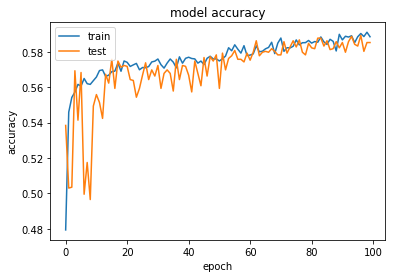

In [762]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

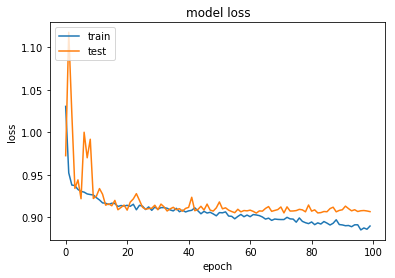

In [763]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [764]:
full_model.evaluate(X_test_inputs, y_test_enc)


2006/2006 [==============================] - 1s 530us/step


[0.9067726417529143, 0.585244266901273]

### With learning rate scheduler, with Dropout

In [748]:
history = full_model.fit(x=X_train_inputs, y=y_train_enc, batch_size=8, shuffle=True, epochs=100, 
          validation_data=(X_test_inputs, y_test_enc), callbacks=[reduce_lr])

Train on 18054 samples, validate on 2006 samples
Epoch 1/100
18054/18054 [==============================] - 14s 775us/step - loss: 1.0086 - acc: 0.4997 - val_loss: 0.9291 - val_acc: 0.5489
Epoch 2/100
18054/18054 [==============================] - 11s 585us/step - loss: 0.9427 - acc: 0.5588 - val_loss: 0.9290 - val_acc: 0.5603
Epoch 3/100
18054/18054 [==============================] - 10s 575us/step - loss: 0.9327 - acc: 0.5657 - val_loss: 0.9246 - val_acc: 0.5613
Epoch 4/100
18054/18054 [==============================] - 11s 596us/step - loss: 0.9327 - acc: 0.5660 - val_loss: 0.9199 - val_acc: 0.5648
Epoch 5/100
18054/18054 [==============================] - 11s 589us/step - loss: 0.9262 - acc: 0.5698 - val_loss: 0.9238 - val_acc: 0.5663
Epoch 6/100
18054/18054 [==============================] - 11s 633us/step - loss: 0.9260 - acc: 0.5744 - val_loss: 0.9214 - val_acc: 0.5658
Epoch 7/100
18054/18054 [==============================] - 11s 631us/step - loss: 0.9205 - acc: 0.5701 - val_lo

Epoch 59/100
18054/18054 [==============================] - 11s 627us/step - loss: 0.9013 - acc: 0.5814 - val_loss: 0.9118 - val_acc: 0.5648
Epoch 60/100
18054/18054 [==============================] - 11s 637us/step - loss: 0.8977 - acc: 0.5834 - val_loss: 0.9091 - val_acc: 0.5708
Epoch 61/100
18054/18054 [==============================] - 9s 511us/step - loss: 0.8959 - acc: 0.5873 - val_loss: 0.9077 - val_acc: 0.5723
Epoch 62/100
18054/18054 [==============================] - 8s 459us/step - loss: 0.8996 - acc: 0.5801 - val_loss: 0.9119 - val_acc: 0.5713
Epoch 63/100
18054/18054 [==============================] - 9s 485us/step - loss: 0.8974 - acc: 0.5832 - val_loss: 0.9108 - val_acc: 0.5688
Epoch 64/100
18054/18054 [==============================] - 9s 475us/step - loss: 0.8965 - acc: 0.5866 - val_loss: 0.9073 - val_acc: 0.5768
Epoch 65/100
18054/18054 [==============================] - 9s 487us/step - loss: 0.8994 - acc: 0.5844 - val_loss: 0.9079 - val_acc: 0.5733
Epoch 66/100
18054

dict_keys(['val_acc', 'val_loss', 'acc', 'loss', 'lr'])


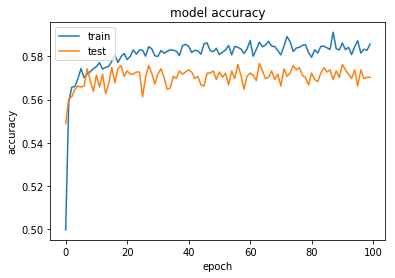

In [749]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

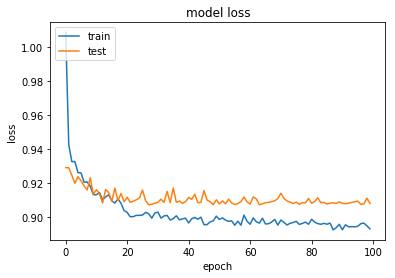

In [750]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### With learning rate scheduler

In [726]:
history = full_model.fit(x=X_train_inputs, y=y_train_enc, batch_size=8, shuffle=True, epochs=100, 
          validation_data=(X_test_inputs, y_test_enc), callbacks=[reduce_lr])

Train on 18054 samples, validate on 2006 samples
Epoch 1/100
18054/18054 [==============================] - 13s 741us/step - loss: 0.9814 - acc: 0.5176 - val_loss: 0.9793 - val_acc: 0.5434
Epoch 2/100
18054/18054 [==============================] - 11s 590us/step - loss: 0.9213 - acc: 0.5716 - val_loss: 0.9499 - val_acc: 0.5558
Epoch 3/100
18054/18054 [==============================] - 11s 624us/step - loss: 0.9159 - acc: 0.5712 - val_loss: 0.9280 - val_acc: 0.5518
Epoch 4/100
18054/18054 [==============================] - 13s 695us/step - loss: 0.9091 - acc: 0.5760 - val_loss: 0.9167 - val_acc: 0.5633
Epoch 5/100
18054/18054 [==============================] - 11s 621us/step - loss: 0.9037 - acc: 0.5789 - val_loss: 0.9263 - val_acc: 0.5573
Epoch 6/100
18054/18054 [==============================] - 12s 641us/step - loss: 0.8995 - acc: 0.5804 - val_loss: 0.9135 - val_acc: 0.5633
Epoch 7/100
18054/18054 [==============================] - 11s 617us/step - loss: 0.8972 - acc: 0.5813 - val_lo

Epoch 59/100
18054/18054 [==============================] - 10s 535us/step - loss: 0.8577 - acc: 0.6047 - val_loss: 0.9111 - val_acc: 0.5808
Epoch 60/100
18054/18054 [==============================] - 9s 524us/step - loss: 0.8574 - acc: 0.6049 - val_loss: 0.9096 - val_acc: 0.5808
Epoch 61/100
18054/18054 [==============================] - 10s 534us/step - loss: 0.8567 - acc: 0.6044 - val_loss: 0.9100 - val_acc: 0.5798
Epoch 62/100
18054/18054 [==============================] - 10s 554us/step - loss: 0.8564 - acc: 0.6036 - val_loss: 0.9080 - val_acc: 0.5783
Epoch 63/100
18054/18054 [==============================] - 10s 541us/step - loss: 0.8557 - acc: 0.6069 - val_loss: 0.9112 - val_acc: 0.5852
Epoch 64/100
18054/18054 [==============================] - 10s 552us/step - loss: 0.8550 - acc: 0.6042 - val_loss: 0.9150 - val_acc: 0.5798
Epoch 65/100
18054/18054 [==============================] - 10s 542us/step - loss: 0.8547 - acc: 0.6067 - val_loss: 0.9094 - val_acc: 0.5798
Epoch 66/100
1

dict_keys(['val_acc', 'val_loss', 'acc', 'loss', 'lr'])


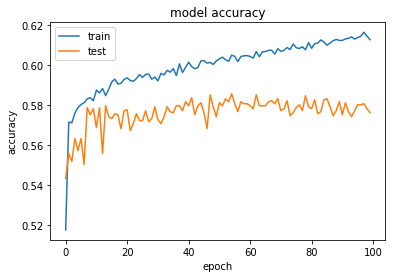

In [727]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

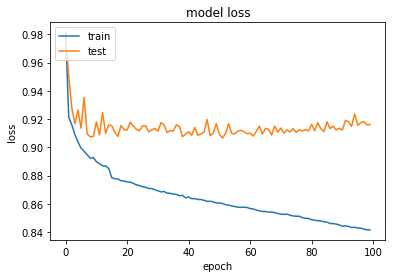

In [728]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [729]:
full_model.save("full_model.h5")

### Without learning rate scheduler

In [714]:
history = full_model.fit(x=X_train_inputs, y=y_train_enc, batch_size=8, shuffle=True, epochs=100, 
          validation_data=(X_test_inputs, y_test_enc), callbacks=[reduce_lr])

Train on 18054 samples, validate on 2006 samples
Epoch 1/100
18054/18054 [==============================] - 13s 740us/step - loss: 1.0596 - acc: 0.4561 - val_loss: 1.0422 - val_acc: 0.4706
Epoch 2/100
18054/18054 [==============================] - 10s 554us/step - loss: 1.0282 - acc: 0.4772 - val_loss: 1.0131 - val_acc: 0.5145
Epoch 3/100
18054/18054 [==============================] - 10s 553us/step - loss: 0.9863 - acc: 0.5198 - val_loss: 0.9718 - val_acc: 0.5389
Epoch 4/100
18054/18054 [==============================] - 10s 550us/step - loss: 0.9543 - acc: 0.5469 - val_loss: 0.9558 - val_acc: 0.5404
Epoch 5/100
18054/18054 [==============================] - 10s 541us/step - loss: 0.9361 - acc: 0.5619 - val_loss: 0.9428 - val_acc: 0.5538
Epoch 6/100
18054/18054 [==============================] - 10s 540us/step - loss: 0.9259 - acc: 0.5666 - val_loss: 0.9412 - val_acc: 0.5628
Epoch 7/100
18054/18054 [==============================] - 10s 548us/step - loss: 0.9198 - acc: 0.5726 - val_lo

Epoch 59/100
18054/18054 [==============================] - 10s 528us/step - loss: 0.8860 - acc: 0.5914 - val_loss: 0.9101 - val_acc: 0.5713
Epoch 60/100
18054/18054 [==============================] - 9s 525us/step - loss: 0.8855 - acc: 0.5923 - val_loss: 0.9158 - val_acc: 0.5728
Epoch 61/100
18054/18054 [==============================] - 11s 625us/step - loss: 0.8855 - acc: 0.5901 - val_loss: 0.9109 - val_acc: 0.5728
Epoch 62/100
18054/18054 [==============================] - 11s 588us/step - loss: 0.8852 - acc: 0.5908 - val_loss: 0.9115 - val_acc: 0.5673
Epoch 63/100
18054/18054 [==============================] - 12s 660us/step - loss: 0.8853 - acc: 0.5897 - val_loss: 0.9093 - val_acc: 0.5723
Epoch 64/100
18054/18054 [==============================] - 11s 612us/step - loss: 0.8854 - acc: 0.5913 - val_loss: 0.9100 - val_acc: 0.5693
Epoch 65/100
18054/18054 [==============================] - 11s 634us/step - loss: 0.8848 - acc: 0.5903 - val_loss: 0.9118 - val_acc: 0.5673
Epoch 66/100
1

dict_keys(['val_acc', 'val_loss', 'acc', 'loss'])


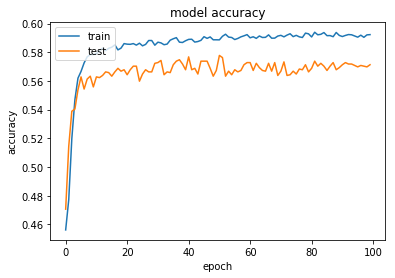

In [715]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

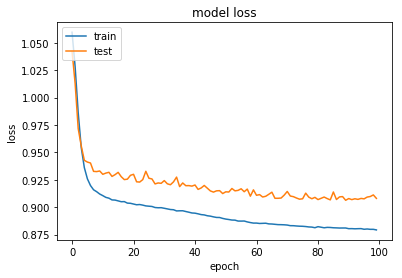

In [716]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()